In [ ]:
# default_exp core

# PyDWI

> Fast ADC and DKI maps from DWI.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#hide
%load_ext autoreload
%autoreload 2

In [ ]:
#export
import pydicom
import numpy as np
import nibabel as nib
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from functools import partial
show = partial(plt.imshow, cmap="gray")
import pandas as pd
from tqdm import tqdm
from joblib import Parallel, delayed
from sklearn.linear_model import LinearRegression
import warnings

In [ ]:
#export
def ADC(pixel, ADC, intercept):
    return ADC*pixel + intercept

In [ ]:
#export
def kurtosis(x, D, K):
        return (-x * D) + ((x **2)* (D **2) * K/6)

In [ ]:
#export
class SliceGroup():
    '''Represents a logical group of slices. Should never be called directly.
    '''
    def __init__(self, df):
        self.df = df

    @property
    def pixel_array(self):
        return np.stack(self.df["pixels"])
    
    def __len__(self):
        return self.pixel_array.shape[0]
    
    def __repr__(self):
         return f"""SliceGroup at position {self.df["z_position"].unique()} with instance numbers {self.df["instance_no"].unique()},
                 b_values {self.df["b_value"].unique()} and {len(self)} slices."""
        
    def show(self, figsize=(20,5)):
        fig, ax = plt.subplots(ncols=len(self), figsize=figsize)
        for i, axi, in enumerate(ax.flat):
            fig.suptitle(f"""Slice position {self.df["z_position"].unique()}""")
            ax[i].imshow(self.pixel_array[i], cmap="gray")
            ax[i].set_title(f"""b {self.df["b_value"].unique()[i]}, instance_no {self.df["instance_no"].unique()[i]}""")

In [ ]:
#export
class DWIDataset():
    '''Represents a DWI dataset from a multiframe DICOM. On loading, the dataset is rescaled and 
       broken up into SliceGroups which represent one slice acquired with different b-values.
       Get information about the Dataset by calling .info.
    '''
    
    def __init__(self, filepath):
        self.filepath = filepath
        self.dataset = pydicom.dcmread(filepath)
        print("Loading and rescaling...")
        self.pixel_array = self.dataset.pixel_array *self.rescale_slope + self.rescale_intercept
        self.df = self._get_logical_groups()
        print("Successfully loaded Dataset")
        
    @property
    def rescale_slope(self):
        rs = set([float(self.dataset.PerFrameFunctionalGroupsSequence[i].PixelValueTransformationSequence[0].RescaleSlope) 
                  for i in range(len(self))])
        if not len(rs) == 1: 
            raise ValueError("More than one rescale slope detected. Processing failed.")
        return rs.pop()
    
    @property
    def rescale_intercept(self):
        rs = set([float(self.dataset.PerFrameFunctionalGroupsSequence[i].PixelValueTransformationSequence[0].RescaleIntercept) 
                  for i in range(len(self))])
        if not len(rs) == 1: 
            raise ValueError("More than one rescale intercept detected. Processing failed.")
        return rs.pop()
    
    def __len__(self):
        return int(self.dataset.NumberOfFrames.real)
    
    def _get_logical_groups(self):
        d = dict()
        func_grps = [self.dataset.PerFrameFunctionalGroupsSequence[i] for i in range(len(self))]
        instance_nums = [int(grp["2005", "140f"][0]["InstanceNumber"].value) for grp in func_grps]
        z_positions = [(round(grp["0020", "9113"][0]["ImagePositionPatient"].value[-1], 2)) for grp in func_grps]
        b_values = [(int(grp.MRDiffusionSequence[0].DiffusionBValue)) for grp in func_grps]
        pixs = [ar for ar in self.pixel_array]
        return pd.DataFrame([z_positions, instance_nums, b_values, pixs], index=["z_position", "instance_no", "b_value","pixels"]).T
    
    @property
    def slice_groups(self):
        '''Contains the logical slice groups of same 
           position slices acquired at different b values.
        '''
        grps = []
        for position in np.unique(self.df["z_position"]):
            grps.append(SliceGroup(self.df[self.df["z_position"]==position]))
        return grps
    
    @property
    def info(self):
        return f'''DICOMDataset with {len(self.pixel_array)} slices in groups of {len(self.df["b_value"].unique())} slices each 
        rescaled with slope {self.rescale_slope:.4f} and intercept {self.rescale_intercept:.4f}.'''
    
    def __repr__(self):
        return self.info

In [ ]:
#export
def get_ADC_map(dataset, bvals="full", diagnostics=False, n_jobs=1):
    '''Fast ADC map calculation from a given dataset.
    b_vals="full" uses all b-values, "reduced" uses up to b600.
    diagnostics=True returns the R-squared value.    
    n_jobs determines how many processes to use. -1 is all available.
    '''
    lr = LinearRegression(n_jobs=n_jobs)
    denominator = dataset[1,...] #b50
    if bvals=="full":
        numerator = dataset[1:,...]
        x = np.array([50,300,600,1000]).reshape(-1,1)
    elif bvals=="reduced":
        numerator = dataset[1:4,...] #b50-600
        x = np.array([50,300,600]).reshape(-1,1)
    else: raise ValueError("""Supported options are 'full' or 'reduced'""")
    ar = np.nan_to_num(np.log(numerator/denominator), nan=0, posinf=0, neginf=0
                      ).reshape(numerator.shape[0], numerator.shape[1]*numerator.shape[2])    
    result = (lr.fit(x, ar).coef_).squeeze() * (-1e3)
    score = lr.score(x, ar)
    if diagnostics:
        return result.reshape(dataset.shape[1], dataset.shape[2]), score
    return result.reshape(dataset.shape[1], dataset.shape[2])

In [ ]:
#export
def get_DK_map(dataset, p0=None, bounds=((1e-5, 1e-2), (4e-3, 2))):
    '''Produces a D and a K-map using b-values 50,300, 600 and 1000.
       p0 and bounds are passed to curve_fit 
    '''
    denominator = dataset[1,...] #b50
    numerator = dataset[1:,...] #b50-1000
    ar = np.nan_to_num(np.log(numerator/denominator), nan=0, posinf=0, neginf=0)
    
    D_map = np.zeros(shape=(ar.shape[1], ar.shape[2]))  
    K_map = np.ones(shape=(ar.shape[1], ar.shape[2]))  
    x = [50,300,600,1000]
    for xx in range(ar.shape[1]):
        for yy in range(ar.shape[2]):
            if ar[:, xx, yy].sum() == 0 or np.all(ar[:,xx,yy] == ar[0,xx,yy]): 
                continue
                continue
            try:
                result = curve_fit(kurtosis, x, ar[:, xx, yy], p0=p0, bounds=bounds)[0]
            except:
                result = (0, 0)
            D_map[xx, yy] = result[0]*1e3
            K_map[xx, yy] = result[1]
    return (D_map, K_map)

In [ ]:
#export
def get_ADC_dataset(dwi_dataset, n_jobs=-1, bvals="full", diagnostics=False, suppress_warnings=True):
    if suppress_warnings:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            adc = np.array([get_ADC_map(slice_group.pixel_array, n_jobs=n_jobs, 
                                        bvals=bvals, diagnostics=diagnostics) 
                            for slice_group in dwi_dataset.slice_groups])
    else:
        adc = np.array([get_ADC_map(slice_group.pixel_array, n_jobs=n_jobs, 
                                        bvals=bvals, diagnostics=diagnostics) 
                            for slice_group in dwi_dataset.slice_groups])
    return adc

In [ ]:
#export
def get_DKI_dataset(dwi_dataset, n_jobs=-1, verbose=1):
    DKI_maps = Parallel(n_jobs=n_jobs, verbose=verbose)(delayed(get_DK_map)(slice_group.pixel_array) 
                                                    for slice_group in dwi_dataset.slice_groups)
    DMaps = np.array(DKI_maps)[:,0,...]
    KMaps = np.array(DKI_maps)[:,1,...]
    return DMaps, KMaps

In [ ]:
#export
def save_nii(ar, filename):
    nib.save(nib.Nifti1Image(np.fliplr(np.rot90(np.transpose(ar[::-1], (1,2,0)))), np.eye(4)), f"{filename}.nii.gz")

In [ ]:
#test
d = DWIDataset("/Users/gkaissis/OneDrive/Projects/Reconstruction/DICOMS/1.dcm")

Loading and rescaling...
Successfully loaded Dataset


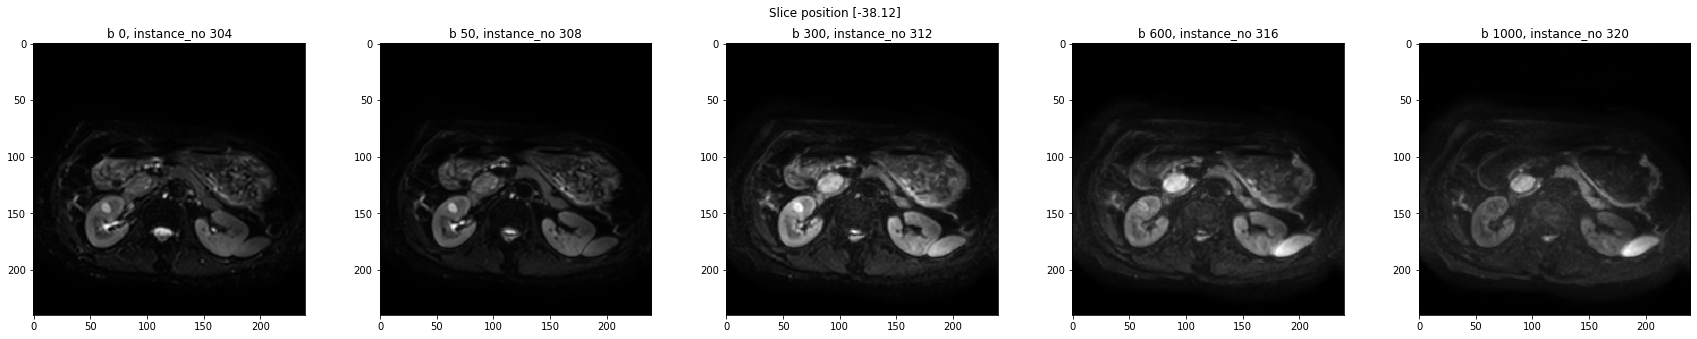

In [ ]:
#test
d.slice_groups[15].show(figsize=(30,5))

In [ ]:
%%time
#test
ADC_maps = get_ADC_dataset(d)
del ADC_maps

CPU times: user 2.54 s, sys: 61.9 ms, total: 2.61 s
Wall time: 341 ms


In [ ]:
#hide
#test
def get_DKI_dataset_test(dwi_dataset, n_jobs=-1, verbose=1):
    DKI_maps = Parallel(n_jobs=n_jobs, verbose=verbose)(delayed(get_DK_map)(slice_group.pixel_array) 
                                                    for slice_group in dwi_dataset.slice_groups[:2])
    DMaps = np.array(DKI_maps)[:,0,...]
    KMaps = np.array(DKI_maps)[:,1,...]
    return DMaps, KMaps

In [ ]:
%%time
#test
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    d, k = get_DKI_dataset_test(d)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


CPU times: user 77 ms, sys: 139 ms, total: 216 ms
Wall time: 1min 44s


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  1.7min finished


In [ ]:
from nbdev.export import notebook2script
notebook2script()

Converted 00_core.ipynb.
Converted index.ipynb.
